# MA556 Group Project

## Part 1: Attain Survey Weights

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.special import expit # Logistic function

# Generate values of z from the normal distribution model
def generate_z(mu_z, sigma_z, N):
    z = np.random.normal(mu_z, sigma_z, N)
    return z

# Calculate the propensity score using logistic regression
def compute_propensity_scores(data, psi, predictors=['Intercept', 'Age', 'Sex', 'Z']):
    # Calculate v'ψ
    linear_predictor = np.dot(data[predictors], psi)

    # Apply the logistic to propensity
    propensity_scores = expit(linear_predictor)

    return propensity_scores

def compute_survey_weights(data, propensity_scores):
    N = len(data)  # Total # individuals
    f = 1 / N  # Sample fraction

    # Calculate W_i
    original_weights = N / propensity_scores

    # Calculate adjusted w_i
    adjusted_weights = f * original_weights / original_weights.mean()

    # Calculate effective sample size n_hat
    n_hat = (original_weights.sum())**2 / (original_weights**2).sum()

    # Calculate final adjusted survey weights
    final_adjusted_weights = n_hat * original_weights / original_weights.sum()

    return final_adjusted_weights


# Import data
data = pd.read_csv('Updated_Project_chromosome.csv')

# Generate values of z
mu_z = 0
sigma_z = 1

N = len(data)
data['Z'] = generate_z(mu_z, sigma_z, N)

# Fit the logistic regression
predictors = ['Intercept', 'Age', 'Sex', 'Z']
response = 'Treatment'

model = sm.Logit(data[response], data[predictors])
results = model.fit()

# The fitted coefficients 'psi'
psi = results.params

# Fit logistic regression
X = data[predictors]
y = data[response]

propensity_scores = compute_propensity_scores(data, psi)
adjusted_weights = compute_survey_weights(data, propensity_scores)

data['AdjustedWeight'] = adjusted_weights

print(data['AdjustedWeight'])


Optimization terminated successfully.
         Current function value: 0.527230
         Iterations 6
0      1.570984
1      1.442786
2      1.377942
3      1.496310
4      0.891107
         ...   
434    0.888328
435    1.271308
436    1.271458
437    1.271449
438    1.264007
Name: AdjustedWeight, Length: 439, dtype: float64


In [15]:
w = data['AdjustedWeight'].to_numpy()

## Depricated Code

In [ ]:
# df = pd.read_csv('data.csv')
# df['Intercept'] = 1
# df['Treatment'] = df['Subject'].apply(lambda x: 0 if 'C' in x else 1)
# df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
# df = df.rename(columns={'Sex_M':'Sex'})

# df.to_csv('data_table.csv')


## Part 2: MCMC

In [22]:
import pymc as pm
import numpy as np

n_samples = len(data.iloc[:39])
x_data = data[['Intercept', 'Treatment', 'Age', 'Sex', 'Z']].iloc[:39].values
y_data = data['y'].iloc[:39].values
treatment_data = data['Treatment'].iloc[:39].values.astype(int)
w_data = data['AdjustedWeight'].iloc[:39].values


with pm.Model() as model:
    b0 = pm.MvNormal('b0', mu=np.zeros(5), cov=np.eye(5), shape=5)
    b1 = pm.MvNormal('b1', mu=np.zeros(5), cov=np.eye(5), shape=5)
    sigma0 = pm.InverseGamma('sigma0', alpha=0.01, beta=0.01)
    sigma1 = pm.InverseGamma('sigma1', alpha=0.01, beta=0.01)
    rho = pm.Uniform('rho', lower=0, upper=1)
    cov_base = pm.math.stack([
        [sigma0**2, rho * sigma0 * sigma1],
        [rho * sigma0 * sigma1, sigma1**2]
    ])
    w_i_reshaped = w_data[:, None, None]
    cov_matrix = cov_base[None, :, :] / w_i_reshaped
    X_cov = x_data
    treatment = treatment_data
    mu_0 = pm.math.dot(X_cov, b0)
    mu_1 = pm.math.dot(X_cov, b1)
    outcomes = pm.MvNormal('outcomes', mu=pm.math.stack([mu_0, mu_1]).T, cov=cov_matrix, shape=(n_samples, 2))
    observed_outcomes = outcomes[np.arange(n_samples), treatment]
    sigma_obs = pm.math.sqrt(1 / w_data[treatment])
    Y_obs = pm.Normal('Y_obs', mu=observed_outcomes, sigma=sigma_obs, observed=y_data)
    trace = pm.sample(500, return_inferencedata=True)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
w_data

array([1.57098418, 1.44278575, 1.37794183, 1.49630956, 0.89110675,
       0.82885274, 0.84190869, 0.83929406, 0.79122346, 1.10269635,
       0.78055191, 0.77262357, 1.04074638, 0.74908444, 0.98031565,
       0.73742802, 1.26997647, 1.02838274, 1.00260854, 1.00472716,
       1.66517597, 0.9068197 , 0.89074541, 0.85125625, 0.88688201,
       0.77201654, 0.78157845, 0.755482  , 0.78052633, 0.77120046,
       0.74229754, 1.10429409, 0.74194562, 0.73578295, 1.0044918 ,
       0.95533449, 0.87544604, 0.71782634, 0.70650818])

## Part 3: Beyesian Predictive Inference

In [23]:
b0 = np.mean(trace.posterior['b0'], axis= 1)[0]

In [24]:
b1 = np.mean(trace.posterior['b1'], axis= 1)[0]

In [25]:
print(b0,b1)

<xarray.DataArray 'b0' (b0_dim_0: 5)>
array([0.22080417, 0.11628041, 0.01221248, 0.02999623, 0.10452004])
Coordinates:
    chain     int64 0
  * b0_dim_0  (b0_dim_0) int64 0 1 2 3 4 <xarray.DataArray 'b1' (b1_dim_0: 5)>
array([ 0.01628416,  0.19091441,  0.03087682,  0.08250813, -1.05403349])
Coordinates:
    chain     int64 0
  * b1_dim_0  (b1_dim_0) int64 0 1 2 3 4


In [55]:
y0_predictions = []
y1_predictions = []
b0_sample = trace.posterior['b0'][0][:439]
b1_sample = trace.posterior['b1'][0][:439]
y0_pred = np.dot(data[['Intercept', 'Treatment', 'Age', 'Sex', 'Z']].values, b0_sample.T)
y1_pred = np.dot(data[['Intercept', 'Treatment', 'Age', 'Sex', 'Z']].values, b1_sample.T)
y0_data = np.mean(y0_pred,axis=0)
y1_data = np.mean(y1_pred,axis=0)

In [56]:
data['y0'] = y0_data
data['y1'] = y1_data

In [57]:
data

,id,Intercept,Treatment,Age,Sex,Z,y,AdjustedWeight,y0,y1
0,1,1.0,0.0,83.0,1.0,-1.266946,2.7,1.570984,1.942428,1.940892
1,2,1.0,0.0,81.0,1.0,0.408594,0.5,1.442786,1.586254,2.326018
2,3,1.0,0.0,80.0,1.0,-0.034418,0.0,1.377942,0.461063,3.164128
3,4,1.0,0.0,82.0,1.0,-1.579915,0.0,1.496310,0.407131,2.240924
4,5,1.0,0.0,66.0,1.0,1.381976,5.0,0.891107,1.904694,3.118745
...,...,...,...,...,...,...,...,...,...,...
434,435,1.0,1.0,66.0,1.0,-0.101307,9999.0,0.888328,0.431435,2.234067
435,436,1.0,1.0,78.0,1.0,0.497827,9999.0,1.271308,0.817753,1.278619
436,437,1.0,1.0,78.0,1.0,0.527204,9999.0,1.271458,1.312844,1.605357
437,438,1.0,1.0,78.0,1.0,0.525550,9999.0,1.271449,0.712352,2.083260


In [58]:
data['TE'] = data['y1'] - data['y0']

#### Estimate ATE

In [59]:
np.mean(data['TE'].values)

1.1422348811519163

In [85]:
#hpd
import arviz as az
ate_samples = np.mean(y1_pred, axis=0) - np.mean(y0_pred, axis=0)
hpd_interval_ate = az.hdi(ate_samples, hdi_prob=0.95)
print(f"The 95% HPD interval for the ATE is: {hpd_interval_ate}")

The 95% HPD interval for the ATE is: [-0.5570292   2.74694106]


# Part 4: Diagnostic


In [78]:
import xarray as xr
def print_full_xarray(da: xr.DataArray or xr.Dataset):
    with xr.set_options(display_width=10000):
        print(da)

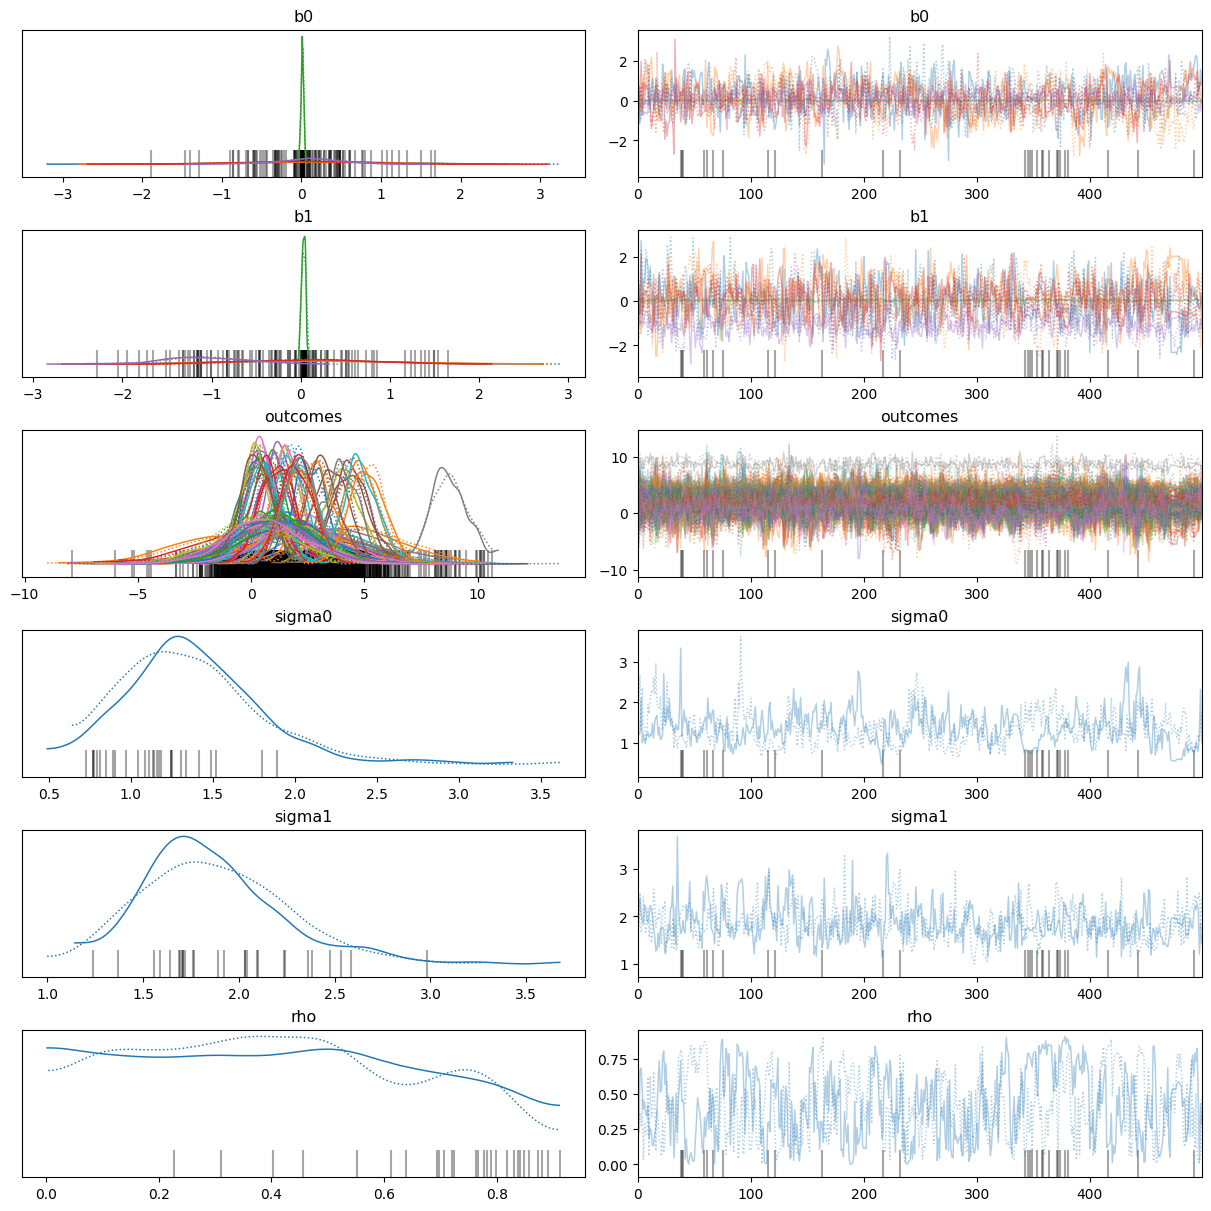

In [69]:
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
pm.plot_trace(trace)
plt.show()

In [79]:
rhat = pm.rhat(trace)
print(rhat)

<xarray.Dataset>
Dimensions:         (b0_dim_0: 5, b1_dim_0: 5, outcomes_dim_0: 39,
                     outcomes_dim_1: 2)
Coordinates:
  * b0_dim_0        (b0_dim_0) int64 0 1 2 3 4
  * b1_dim_0        (b1_dim_0) int64 0 1 2 3 4
  * outcomes_dim_0  (outcomes_dim_0) int64 0 1 2 3 4 5 6 ... 33 34 35 36 37 38
  * outcomes_dim_1  (outcomes_dim_1) int64 0 1
Data variables:
    b0              (b0_dim_0) float64 0.9995 1.067 1.0 0.9996 1.006
    b1              (b1_dim_0) float64 1.002 1.033 1.007 1.0 1.0
    outcomes        (outcomes_dim_0, outcomes_dim_1) float64 1.002 ... 1.006
    sigma0          float64 1.004
    sigma1          float64 1.017
    rho             float64 1.009


In [80]:
print_full_xarray(rhat)

<xarray.Dataset>
Dimensions:         (b0_dim_0: 5, b1_dim_0: 5, outcomes_dim_0: 39, outcomes_dim_1: 2)
Coordinates:
  * b0_dim_0        (b0_dim_0) int64 0 1 2 3 4
  * b1_dim_0        (b1_dim_0) int64 0 1 2 3 4
  * outcomes_dim_0  (outcomes_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
  * outcomes_dim_1  (outcomes_dim_1) int64 0 1
Data variables:
    b0              (b0_dim_0) float64 0.9995 1.067 1.0 0.9996 1.006
    b1              (b1_dim_0) float64 1.002 1.033 1.007 1.0 1.0
    outcomes        (outcomes_dim_0, outcomes_dim_1) float64 1.002 1.018 0.9997 1.023 1.004 1.016 1.002 1.01 1.003 1.007 1.002 1.01 1.005 1.01 1.002 1.005 1.006 1.008 1.003 1.008 1.0 1.016 1.004 1.015 1.001 1.006 1.001 1.007 1.004 1.013 1.002 1.005 1.041 1.001 1.021 1.005 1.028 1.001 1.032 0.9999 1.039 1.008 1.026 1.0 1.018 1.001 1.016 1.004 1.028 1.008 1.021 1.006 1.018 0.9992 1.019 1.0 1.018 0.9993 1.024 1.001 1.031 1.004 1.031 1.001 1.0

In [81]:
ess = pm.ess(trace)
print_full_xarray(ess)

<xarray.Dataset>
Dimensions:         (b0_dim_0: 5, b1_dim_0: 5, outcomes_dim_0: 39, outcomes_dim_1: 2)
Coordinates:
  * b0_dim_0        (b0_dim_0) int64 0 1 2 3 4
  * b1_dim_0        (b1_dim_0) int64 0 1 2 3 4
  * outcomes_dim_0  (outcomes_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
  * outcomes_dim_1  (outcomes_dim_1) int64 0 1
Data variables:
    b0              (b0_dim_0) float64 446.1 29.12 409.7 381.9 430.1
    b1              (b1_dim_0) float64 417.8 112.4 255.0 504.4 352.3
    outcomes        (outcomes_dim_0, outcomes_dim_1) float64 552.7 279.4 743.4 128.9 571.9 231.7 520.0 290.1 232.3 211.8 829.7 252.9 569.0 202.8 931.0 291.8 536.8 380.4 774.9 384.8 531.0 208.9 572.9 303.3 761.5 310.5 793.2 353.2 896.8 364.8 572.3 213.5 54.55 667.7 275.0 784.0 150.3 602.2 217.2 825.3 80.35 537.3 114.0 626.0 270.5 671.9 226.5 680.7 142.4 659.9 264.7 666.4 368.9 1.03e+03 186.9 1.021e+03 171.1 861.8 167.5 1.035e+03 140.1 9

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (182) in plot_autocorr, generating only 40 plots
  warnings.warn(


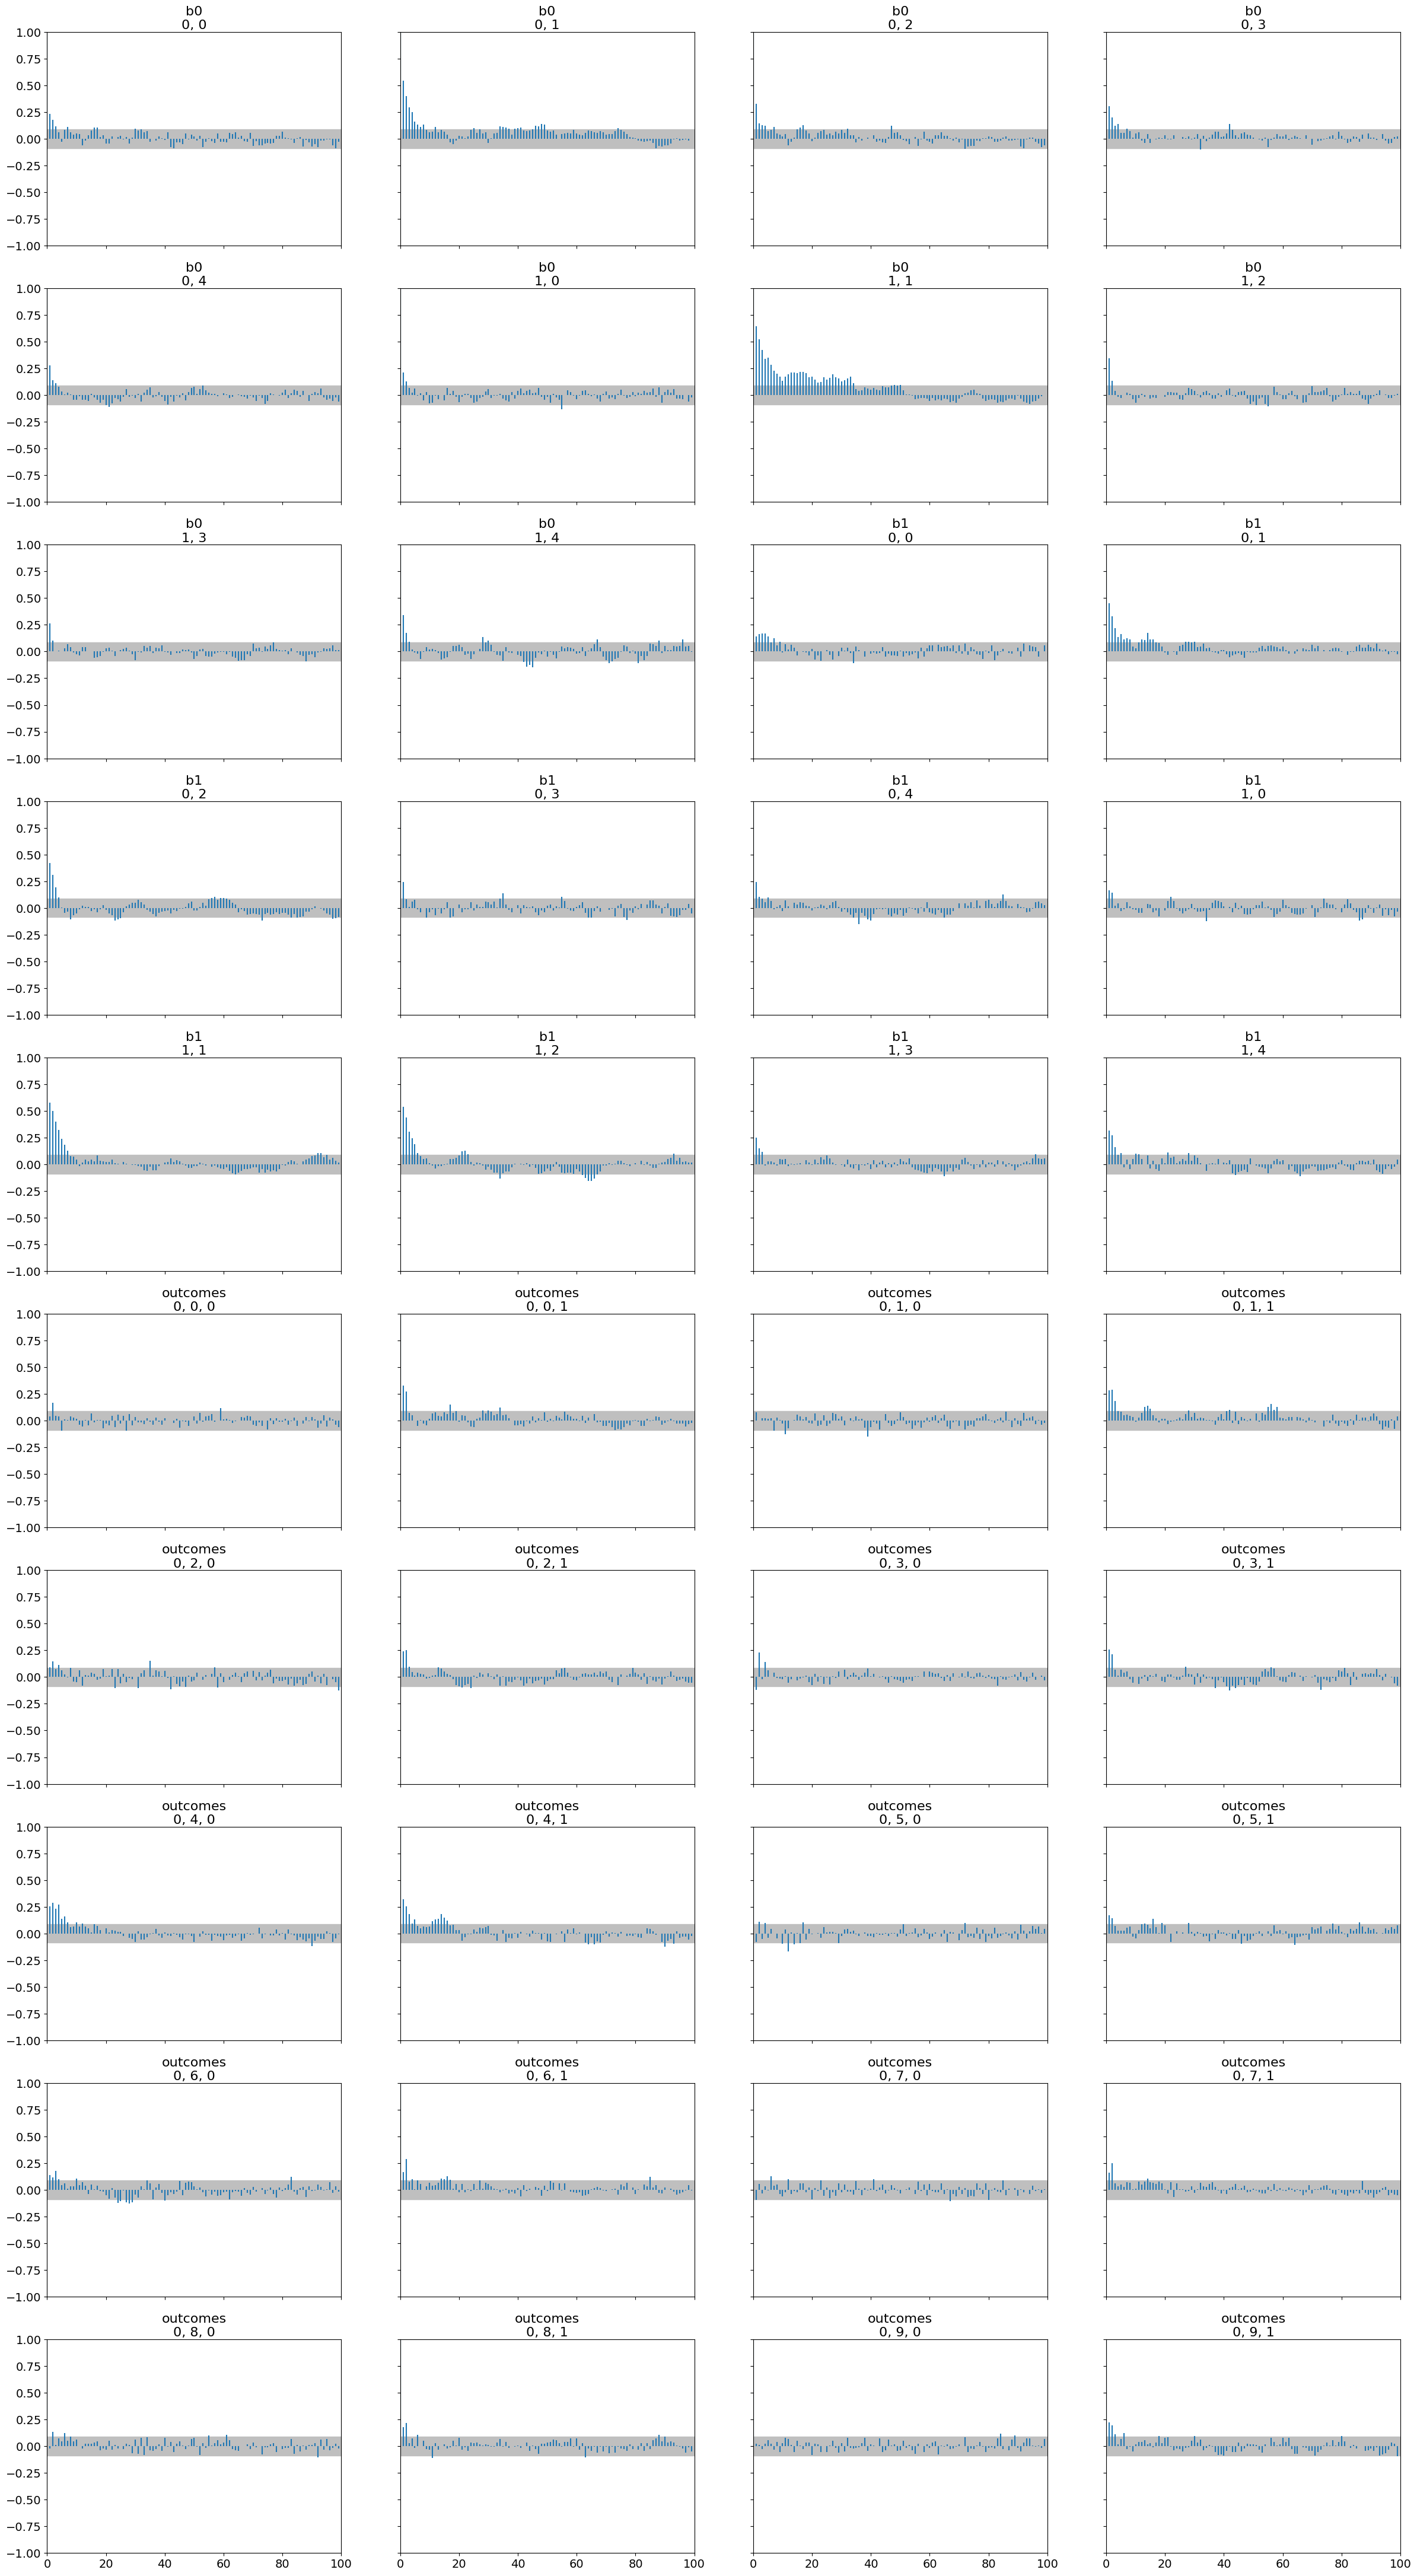

In [64]:
pm.plot_autocorr(trace)
plt.show()

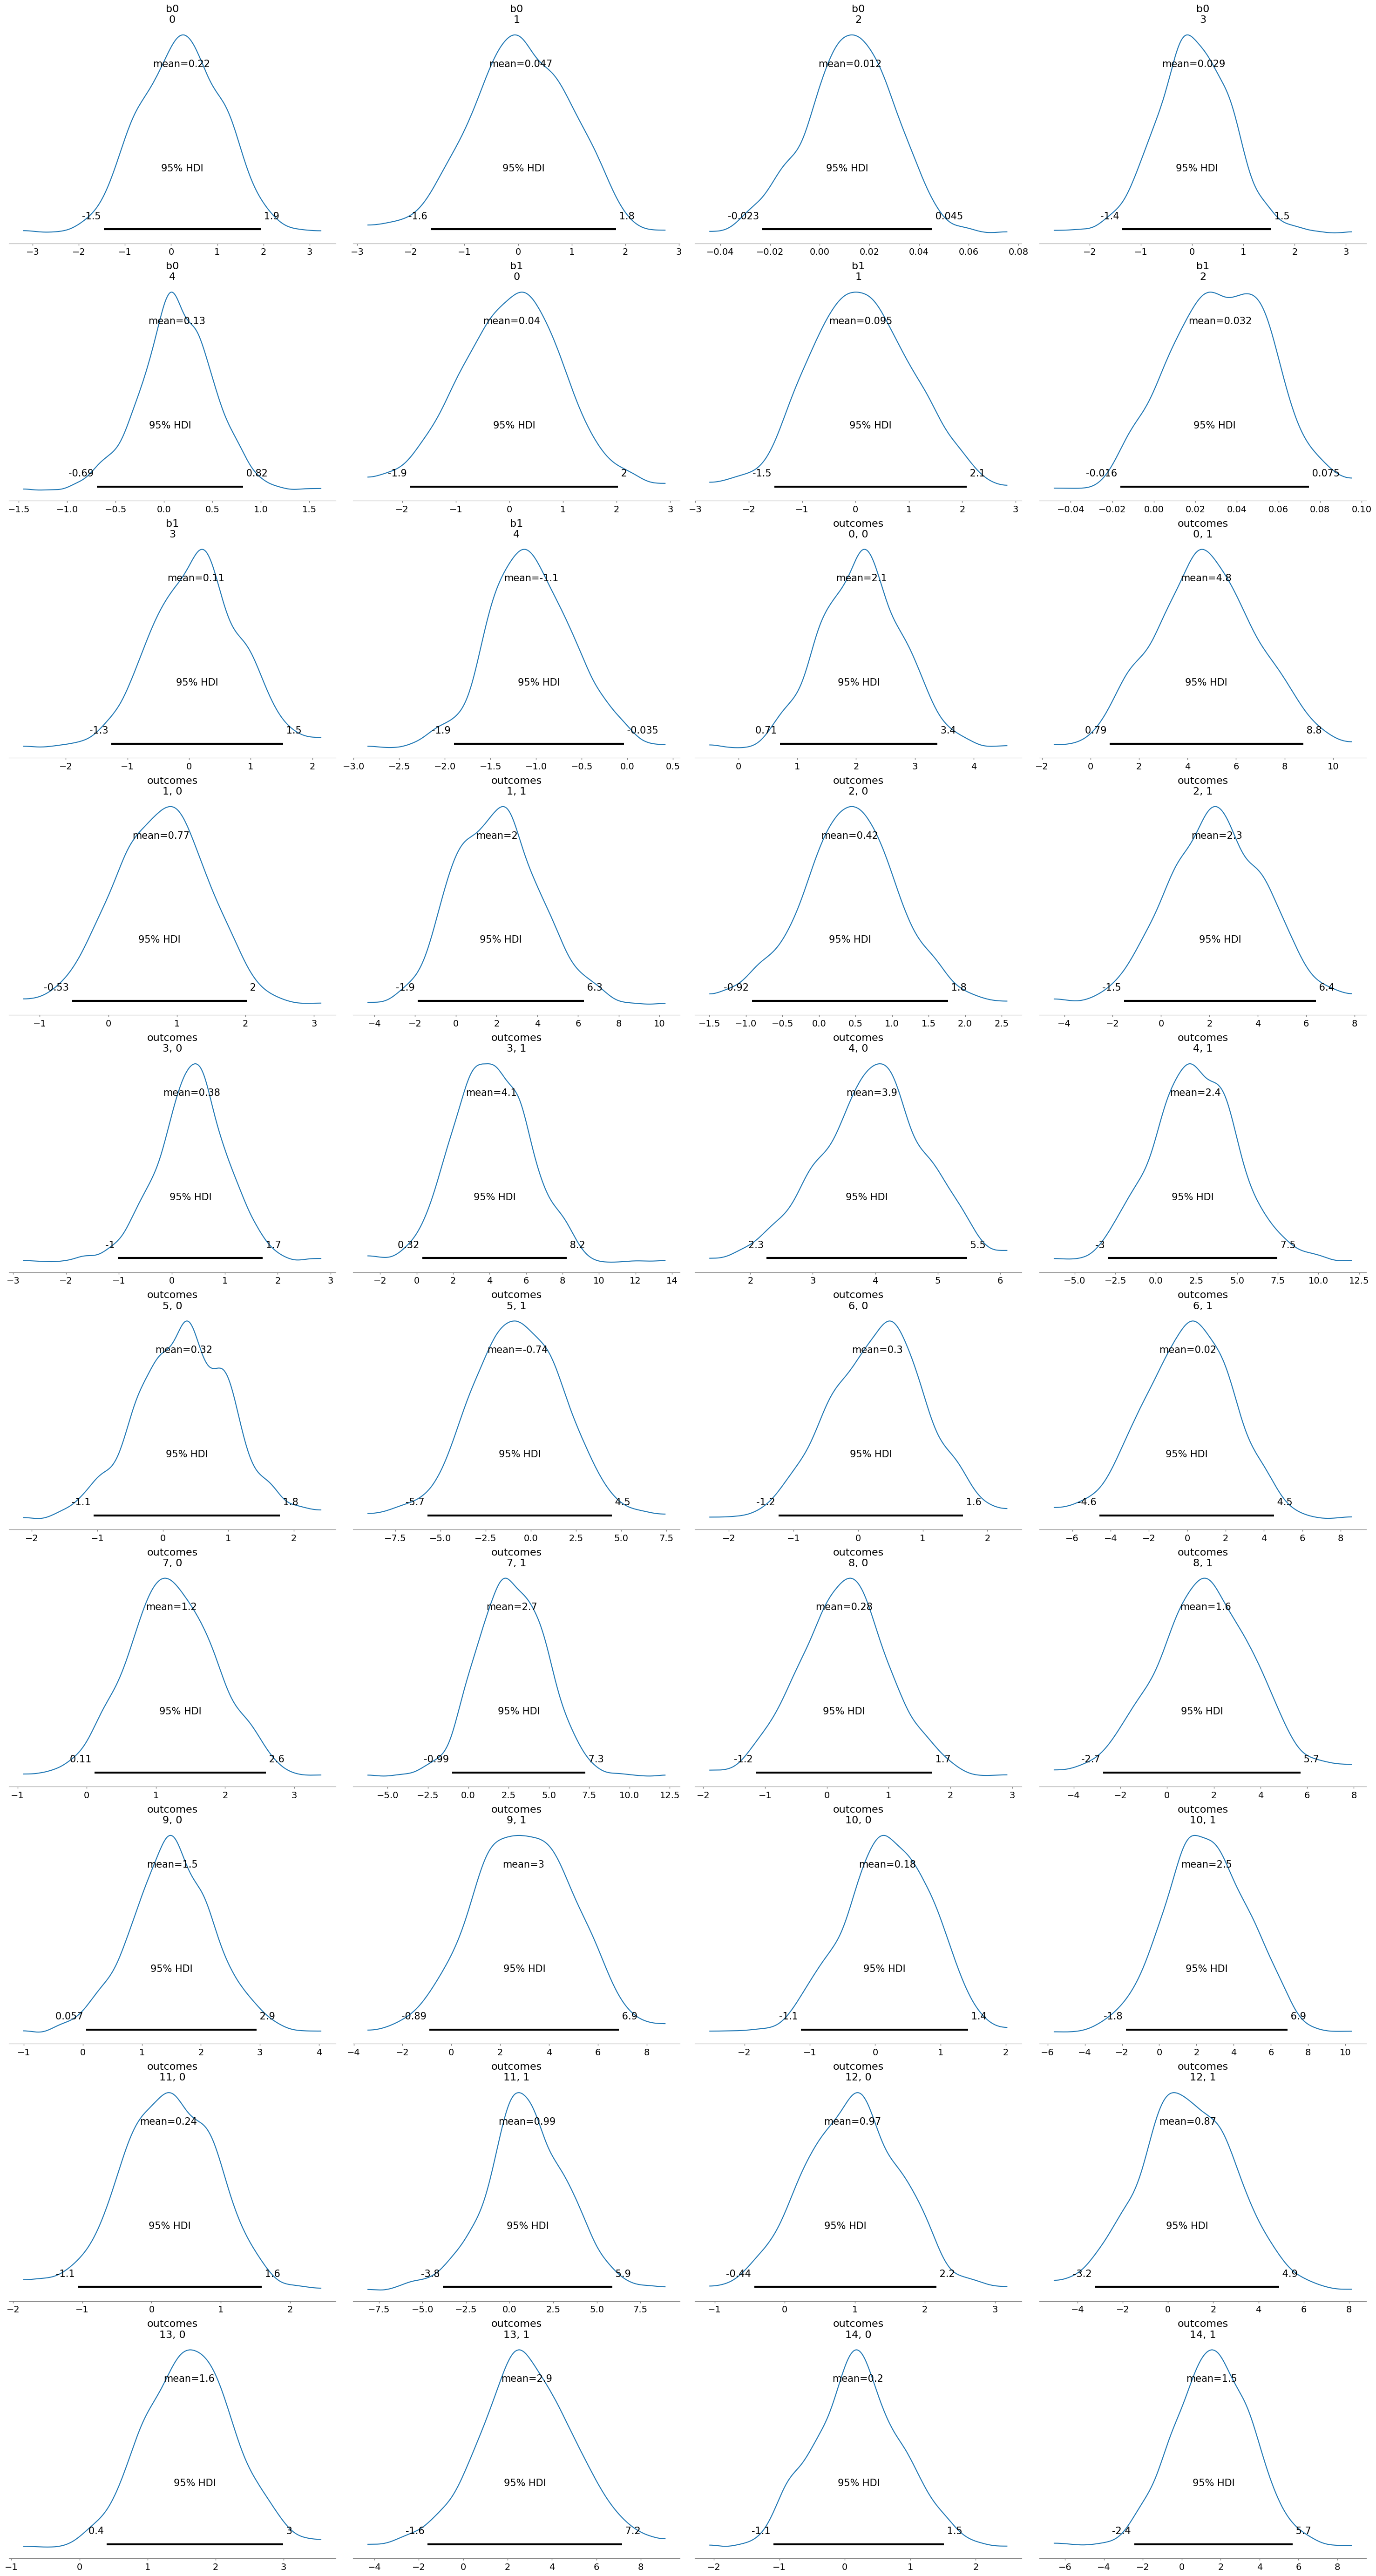

In [73]:
plt.rcParams['figure.constrained_layout.use'] = True
pm.plot_posterior(trace,hdi_prob=0.95)
plt.show()

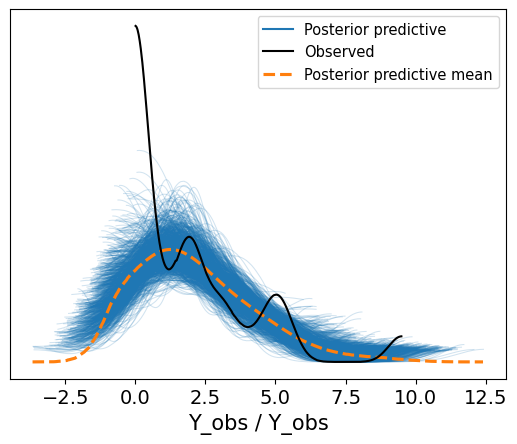

In [65]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=['Y_obs'])
    pm.plot_ppc(ppc)
    plt.show()